In [17]:
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from mpl_toolkits.axes_grid.inset_locator import inset_axes

from statsmodels.stats.proportion import proportion_confint
import statsmodels.api as sm

import pymc3
from scipy import stats
from scipy.optimize import curve_fit

import sklearn as skl
from sklearn.metrics import roc_curve
from sklearn.calibration import calibration_curve


def iso_skill(x, y, br):
    unc=br*(1-br)
    return ((y-br)**2 - (x-y)**2)/unc

def get_ci_freq(p,n):
    # Get CI for ratios (sens/spec/accuracy/ppv/npv) and likelihood ratios
    # Newcombe, Robert G. "Two-Sided Confidence Intervals for the Single Proportion: Comparison of Seven Methods," Statistics in Medicine, 17, 857-872 (1998).

    z=1.96
    q = 1 - p
    ci_lower = (2 * n * p + z*z - 1 - z * math.sqrt(z*z - 2 - 1/n + 4 * p * (n * q + 1)))/(2 * (n + z*z))
    ci_upper = (2 * n * p + z*z + 1 + z * math.sqrt(z*z + 2 - 1/n + 4 * p * (n * q - 1)))/(2 * (n + z*z))
    se=(ci_upper-ci_lower)/3.92

    return (ci_lower,ci_upper),se

def get_ci_lr(sign,cm):

    tp=cm[1,1]     #a
    fp=cm[0,1]     #b
    fn=cm[1,0]     #c
    tn=cm[0,0]     #d
    sens=tp/(tp+fn)
    spec=tn/(tn+fp)
    
    keepgoing=True

    if ( tp==0 and fp !=0):
        tp=0.5
    elif (tp!=0 and fp==0):
        fp=0.5
    elif ( (tp==(tp+fn)) and  (fp==(fp+tn) )):
        tp=tp-0.5
        fp=fp-1.5
        
    if (fn==0 and tn!=0):
        fn=0.5
    elif (fn!=0 and tn==0):
        tn=0.5
    elif ( (fn==(fn+tp)) and (tn==(tn+fp)) ):
        fn=fn-0.5
        tn=tn-0.5   
    
    if sign=="+":
        p1=sens
        p2=1-spec
        p1n1=tp
        p2n2=fp
    elif sign=="-":
        p1=1-sens
        p2=spec
        p1n1=fn
        p2n2=tn
    else:
        keepgoing=False
    
    if keepgoing:
        
        n1=tp+fp
        n2=tn+fn
        
        ci_lower=np.exp( np.log(p1/p2) - 1.96*np.sqrt((1-p1)/(p1n1) + (1-p2)/(p2n2) )  )
        ci_upper=np.exp( np.log(p1/p2) + 1.96*np.sqrt((1-p1)/(p1n1) + (1-p2)/(p2n2) )  )
    else:
        ci_lower=float('nan')
        ci_upper=float('nan')
    
    se=(ci_upper-ci_lower)/3.92

    return (ci_lower,ci_upper),se


def get_ci_calib(metric_array):
    # Get 95% CIs for calibration metrics

    # First, check to make sure array is not empty.
    # If it is, return empty results
    
    if not metric_array:
        ci_lower=float('nan')
        ci_upper=float('nan')
        se=float('nan')
    else:
        alpha = 0.95
        p = ((1.0-alpha)/2.0) * 100
        ci_lower = max(0.0, np.percentile(metric_array, p))
        p = (alpha+((1.0-alpha)/2.0)) * 100
        ci_upper = min(1.0, np.percentile(metric_array, p))
        se=(ci_upper-ci_lower)/3.92

    return (ci_lower, ci_upper),se

def get_hpd(metric_array):
    # Get 95% HPDs for calibration metrics

    # First, check to make sure array is not empty.
    # If it is, return empty results
    
    if not metric_array:
        hpd=[float('nan'),float('nan')]
    else:
        hpd=pymc3.stats.hpd(np.array(metric_array))
        
    return hpd


def format_number(num):
    if abs(num)<0.001:
        x="0"
    else:
        x=str(float('%.2g' % num))
    return(x)

def calibration_loss(truth,forecast):
    # Calculates calibration loss and the Sanders score
    # Returns the array (needs to be summed later to get the number)
    
    # Assumes we don't need to re-bin)
    N=len(truth)
    levels=list(set(forecast))
    levels.sort()
    K=len(levels)
    calibration_loss_array=[]
    sanders_array=[]

    for pk in levels:
        nk=np.count_nonzero(forecast == pk)
        i=sum(np.where(forecast == pk))
        obark=sum(truth[i])/nk
        calibration_loss_array.append((nk/N)*((pk-obark)**2))
        sanders_array.append( (pk-obark)**2 + obark*(1-obark))

    return (calibration_loss_array,sanders_array)
    

def overconfidence_score(truth,forecast):
    
    # https://github.com/mlr-org/mlr/issues/842
    # Convert to numpy arrays
    forecast=np.array(forecast)
    truth=np.array(truth)
    
    # Generate the half-range forecasts 
    # i.e., Fold the array at 0.5 
    forecast_half_range=np.abs(forecast-0.5)+0.5
    
    # initialize the accuracy array, assume all are incorrect
    accurate=np.zeros(len(truth))

    # set the ones that are correct. 0.5 can go either way, so just pick
    accurate[np.where((forecast<=0.5) & (truth==0))[0]]=1
    accurate[np.where((forecast>0.5) & (truth==1))[0]]=1
    
    
    return(sum((forecast_half_range-accurate)/len(truth)))

def confidence_function_1(pp,k):
    p=np.array(pp)
    return p**k / (p**k + (1-p)**k)

def confidence_function(pp,a,b,c,d):
    p=np.array(pp)
    return (p**a / (p**b + (1-p)**c))/d


### Radar chart section
### Modified from https://matplotlib.org/gallery/api/radar_chart.html

def create_data_for_radar_plot(metrics,array_of_metrics):

    names=[]
    params=[]

    for i in range(0,len(array_of_metrics)):
        name=array_of_metrics[i]
        metric=metrics[name][0]
        metric_min=metrics[name][4]
        metric_max=metrics[name][5]

        if (name=='Calibration loss' or name=='Brier score loss'):  
            metric=1-metric
        if (name=='Refinement loss'):  
            metric=metric/metric_max
            metric=1-metric
        if (name=='Resolution'):
            metric=metric/metric_max
        if (name=='Brier skill score'):
            if metric<0:
                metric=0
        if (name=='Calib-in-the-large' or name=='Confidence score'):  
            metric=1-np.abs(metric)

        names.append(name)
        params.append(metric)
        
        data=[names, params]

    return data


def plot_radar_chart(data,forecaster_names=['Forecaster 1','Forecaster 2'],plot_file_name='radar.png'):

    def radar_factory(num_vars, frame='circle'):

        # calculate evenly-spaced axis angles
        theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

        def draw_poly_patch(self):
            # rotate theta such that the first axis is at the top
            verts = unit_poly_verts(theta + np.pi / 2)
            return plt.Polygon(verts, closed=True, edgecolor='k')

        def draw_circle_patch(self):
            # unit circle centered on (0.5, 0.5)
            return plt.Circle((0.5, 0.5), 0.5)

        patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
        if frame not in patch_dict:
            raise ValueError('unknown value for `frame`: %s' % frame)

        class RadarAxes(PolarAxes):

            name = 'radar'
            # use 1 line segment to connect specified points
            RESOLUTION = 1
            # define draw_frame method
            draw_patch = patch_dict[frame]

            def __init__(self, *args, **kwargs):
                super(RadarAxes, self).__init__(*args, **kwargs)
                # rotate plot such that the first axis is at the top
                self.set_theta_zero_location('N')

            def fill(self, *args, **kwargs):
                """Override fill so that line is closed by default"""
                closed = kwargs.pop('closed', True)
                return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

            def plot(self, *args, **kwargs):
                """Override plot so that line is closed by default"""
                lines = super(RadarAxes, self).plot(*args, **kwargs)
                for line in lines:
                    self._close_line(line)

            def _close_line(self, line):
                x, y = line.get_data()
                # FIXME: markers at x[0], y[0] get doubled-up
                if x[0] != x[-1]:
                    x = np.concatenate((x, [x[0]]))
                    y = np.concatenate((y, [y[0]]))
                    line.set_data(x, y)

            def set_varlabels(self, labels):
                self.set_thetagrids(np.degrees(theta), labels)

            def _gen_axes_patch(self):
                return self.draw_patch()

            def _gen_axes_spines(self):
                if frame == 'circle':
                    return PolarAxes._gen_axes_spines(self)
                # The following is a hack to get the spines (i.e. the axes frame)
                # to draw correctly for a polygon frame.

                # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
                spine_type = 'circle'
                verts = unit_poly_verts(theta + np.pi / 2)
                # close off polygon by repeating first vertex
                verts.append(verts[0])
                path = Path(verts)

                spine = Spine(self, spine_type, path)
                spine.set_transform(self.transAxes)
                return {'polar': spine}

        register_projection(RadarAxes)
        return theta


    def unit_poly_verts(theta):
        x0, y0, r = [0.5] * 3
        verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
        return verts

    
    spoke_labels = data.pop(0)

    N = len(data[0])
    theta = radar_factory(N, frame='polygon')

    fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1, subplot_kw=dict(projection='radar'))

    colors = ['r', 'b']

    for i in range(0,len(data)):
        forecaster=data[i]
        color=colors[i]
        ax.plot(theta, forecaster, color=color)
        ax.fill(theta, forecaster, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot if more than 1 forecaster
    if len(data)>1:
        labels = (forecaster_names)
        legend = ax.legend(labels, loc=(0.9, .95), labelspacing=0.1, fontsize='small')

    return plt
#####

def plot_calib_results(truth, forecast, plot_ci=True, plot_isoskill=False, nplots=3, fig_title="",n_bins=20):


    # Get rid of too much precision in the forecasts 
    # We just need one decimal point here. This also helps
    # with binning later
    forecast=np.round(forecast,2)
    
    
    #####################################
    # Data for the plots
    # Calibration Curve
    calib_y, calib_x = calibration_curve(truth, forecast,n_bins=n_bins)
    # ROC curve
    fpr, tpr, thresholds = roc_curve(truth, forecast,pos_label=1)
    #####################################
    
    #####################################
    # Get 95% CI for the calibration plot
    # Get a list of the bins of calib_y
    #####################################
    # Get the counts for each item in calib_x
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(forecast, bins) - 1
    bin_forecasts = np.bincount(binids, minlength=len(bins))
    bin_forecasts=bin_forecasts[bin_forecasts != 0]
    ci=[]
    i=0

    for prob in calib_y:
        p=prob
        n=bin_forecasts[i]
        AA=proportion_confint(count=n*p, nobs=n, alpha=0.05, method='binom_test')

        ci.append(AA)
        i=i+1
    # Transpose ci and subtract from midpoint so it'll work with pyplot.errorbar
    ci_adj=np.transpose(ci)
    ci_adj[0,]=calib_y-ci_adj[0,]
    ci_adj[1,]=ci_adj[1,]-calib_y
    #####################################
        
    #####################################
    # Get the metrics
    base_rate=sum(truth)/len(truth)
    uncertainty=base_rate*(1-base_rate)
    sharpness=np.var(forecast)

    # Calibration metrics
    brier=skl.metrics.brier_score_loss(truth,forecast)
    (temp_cl,sanders)=calibration_loss(truth=truth,forecast=forecast)
    calibration=sum(temp_cl)
    overconfidence=overconfidence_score(truth,forecast)
    cil=np.mean(forecast)-np.mean(truth)
    resolution=calibration+uncertainty-brier
    refinement=brier-calibration
    brier_base=uncertainty
    brier_skill_score=-(brier-brier_base)/brier_base
    min_bss=(uncertainty-1)/uncertainty

    # Discrimination metrics
    AUC=skl.metrics.auc(fpr,tpr)
    cm=skl.metrics.confusion_matrix(truth,forecast.round())
    tp=cm[1,1]
    tn=cm[0,0]
    fp=cm[0,1]
    fn=cm[1,0]
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)
    accuracy=(tp+tn)/(len(truth))
    ppv=tp/(tp+fp)
    npv=tn/(tn+fn)
    lrp=sensitivity/(1-specificity)
    lrn=(1-sensitivity)/specificity
    
    # Get CI and SE using frequentist method
    sensitivity_ci_f, sensitivity_se=get_ci_freq(sensitivity,tp+fn)
    specificity_ci_f, specificity_se=get_ci_freq(specificity,tn+fp)
    accuracy_ci_f, accuracy_se=get_ci_freq(accuracy,len(truth))
    ppv_ci_f, ppv_se=get_ci_freq(ppv,tp+fp)
    npv_ci_f, npv_se=get_ci_freq(npv,tn+fn)
    lrp_ci_f, lrp_se=get_ci_lr("+",cm)
    lrn_ci_f, lrn_se=get_ci_lr("-",cm)

    ###############################
    # Bootstrap CIs
    # configure bootstrap
    n_iterations = 1000

    # Define arrays to collect bootstraps
    uncertainty_a =list()
    brier_a =list()
    calibration_a =list()
    overconfidence_a =list()
    cil_a=list()
    resolution_a=list()
    refinement_a=list()
    brier_skill_score_a=list()
    auc_a=list()

    sensitivity_a=list()
    specificity_a=list()
    accuracy_a=list()

    values=np.column_stack((forecast,truth))
    data_size = len(truth) # find length of the data set
    
    for x in range(0, n_iterations-1):

        # create an array of random indices equal to data_size
        # this array will be used to sample with replacement from the arrays
        idx = np.random.randint(data_size, size=data_size)
        truth_s = truth[idx]

        # sample from forecasts
        forecast_s = forecast[idx]

        base_rate_s=sum(truth_s)/len(truth_s)
        uncertainty_s=base_rate_s*(1-base_rate_s)

        if uncertainty_s>0:

            brier_s=skl.metrics.brier_score_loss(truth_s,forecast_s)
            (temp_cl_s,sanders_s)=calibration_loss(truth_s,forecast_s)
            calibration_s=sum(temp_cl_s)
            overconfidence_s=overconfidence_score(truth_s,forecast_s)
            cil_s=np.mean(forecast_s)-np.mean(truth_s)
            resolution_s=calibration_s+uncertainty_s-brier_s
            refinement_s=brier_s-calibration_s
            brier_base_s=uncertainty_s
            brier_skill_score_s=-(brier_s-brier_base_s)/brier_base_s

            fpr_s, tpr_s, thresholds_s = roc_curve(truth_s, forecast_s,pos_label=1)
            auc_s=skl.metrics.auc(fpr_s,tpr_s)

            cm_s=skl.metrics.confusion_matrix(truth_s,forecast_s.round())
            tp_s=cm[1,1]
            tn_s=cm[0,0]
            fp_s=cm[0,1]
            fn_s=cm[1,0]
            sensitivity_s=tp_s/(tp_s+fn_s)
            specificity_s=tn_s/(tn_s+fp_s)
            accuracy_s=(tp_s+tn_s)/(len(truth_s))
            uncertainty_a.append(uncertainty_s)
            brier_a.append(brier_s)
            calibration_a.append(calibration_s)
            overconfidence_a.append(overconfidence_s)
            cil_a.append(cil_s)
            resolution_a.append(resolution_s)
            refinement_a.append(refinement_s)
            brier_skill_score_a.append(brier_skill_score_s)
            auc_a.append(auc_s)
            sensitivity_a.append(sensitivity_s)
            specificity_a.append(specificity_s)
            accuracy_a.append(accuracy_s)

        else:
            x=x-1

    # Get CI and SE using frequentist method
    brier_ci,brier_se=get_ci_calib(brier_a)
    calibration_ci,calibration_se=get_ci_calib(calibration_a)
    overconfidence_ci,overconfidence_se=get_ci_calib(overconfidence_a)
    cil_ci,cil_se=get_ci_calib(cil_a)
    resolution_ci,resolution_se=get_ci_calib(resolution_a)
    refinement_ci,refinement_se=get_ci_calib(refinement_a)
    brier_skill_score_ci,brier_skill_score_se=get_ci_calib(brier_skill_score_a)
    auc_ci,auc_se=get_ci_calib(auc_a)
    
    # Get CI using 95%HPD
    uncertainty_ci=get_hpd(uncertainty_a)
    brier_ci=get_hpd(brier_a)
    calibration_ci=get_hpd(calibration_a)
    overconfidence_ci=get_hpd(overconfidence_a)
    resolution_ci=get_hpd(resolution_a)
    refinement_ci=get_hpd(refinement_a)
    brier_skill_score_ci=get_hpd(brier_skill_score_a)
    auc_ci=get_hpd(auc_a)
    sensitivity_ci=get_hpd(sensitivity_a)
    specificity_ci=get_hpd(specificity_a)
    accuracy_ci=get_hpd(accuracy_a)

    # Get Zombie plot ellipse coordinates
    ellipse_width=specificity_ci_f[1]-specificity_ci_f[0]
    ellipse_height=sensitivity_ci_f[1]-sensitivity_ci_f[0]
    ellipse_center=[]
    ellipse_center=[1-(specificity_ci_f[0]+ellipse_width/2),sensitivity_ci_f[0]+ellipse_height/2]

    #####################################
    
    if plot_isoskill:
        # Get equal skill lines
        ls = np.linspace(0.0,1.0,100)
        X, Y = np.meshgrid(ls,ls)
        Z = iso_skill(X,Y,base_rate)

    #####################################
    # Plots
    # Set figure defaults
    fig_height=6
    fig_width=13

    if (nplots==3):
        f, axs = plt.subplots(1,3,figsize=(fig_width,fig_height))
        title_size=14
        axis_size=13
        tick_size=12
        marker_size=7
        line_width=2
        auc_font_size=12
        sup_y=0.9
    else:
        f, axs = plt.subplots(1,2,figsize=(fig_width,fig_height))
        title_size=18
        axis_size=16
        tick_size=14
        marker_size=10
        line_width=2.5
        auc_font_size=16
        sup_y=1.03

    f.suptitle(fig_title, fontsize=24, ha="center",y=sup_y)

    ###########################################################################
    # Plot the confidence  calibration curve
    axs[0].errorbar(calib_x,calib_y,yerr=ci_adj,fmt='o-',capsize=4,markersize=marker_size,linewidth=line_width)

    # Plot the diagnonal
    axs[0].plot([0,1],[0,1],'k-',linewidth=line_width/2)
    # Plot the base rate
    axs[0].plot([0,1],[base_rate,base_rate],'k--',linewidth=line_width/2)
    # Plot the skill area
    x1=[0,base_rate,1]
    y1=[base_rate/2., base_rate,(1+base_rate)/2.]
    axs[0].fill_between(x1[0:2],0,y1[0:2], color="green",alpha=0.1)
    axs[0].fill_between(x1[1:3],y1[1:3],1, color="green",alpha=0.1)

    # Plot lines of optimal resolution
    axs[0].plot([0,base_rate],[0,0],'g:')
    axs[0].plot([base_rate,1],[1,1],'g:')

    # Plot lines of optimal accuracy
    epsilon=0.0
    axs[0].plot([0,0.5],[0+epsilon,0+epsilon],'g-.')
    axs[0].plot([0.5,1],[1-epsilon,1-epsilon],'g-.')

    # Plot isoskill lines if needed
    if plot_isoskill:
        # Find minimum skill given the prevalence. 
        # Used to get a reasonable range of contours
        min_skill=round((uncertainty-1)/uncertainty,1)

        # Set floor at -10, since it can get to -inf at low uncertainty
        if (min_skill<-10):
            min_skill=-10

        # Get a rounded step size from min skill to 0
        interval=(0-min_skill)/5
        # Create a range from min_skill to zero
        neg_interval=np.round(np.arange(min_skill,0,interval),0)
        # Add positive range of skill from 0 to 1, in increments of 0.2
        combined_interval=np.unique(np.concatenate((neg_interval,np.arange(0,1.1,0.2))))

        # Create the iso-contour lines and add to axs[0]
        contours = axs[0].contour(X,Y,Z, combined_interval, colors="green", alpha=0.7)
        axs[0].clabel(contours, inline=True, fontsize=8)


    #########################################################################################
    # Plot the sharpness histogram
    # Set location of sharpness histogram under the confidence calibration curve
    if nplots==3:
        ax_inset=inset_axes(axs[0], width="100%",  height="40%", bbox_to_anchor=(-0.025,-0.7,1,.65), loc=2, bbox_transform=axs[0].transAxes)
    else:
        ax_inset=inset_axes(axs[0], width="100%",  height="40%", bbox_to_anchor=(-0.015,-0.7,1,.65), loc=2, bbox_transform=axs[0].transAxes)
    
    # Set the width of the bins. If there's only one bin and set the width at 0.1
    if (len(calib_x)>1):
        bar_width=min([0.1,min(np.ediff1d(calib_x))])
    else:
        bar_width=0.1

    # Plot the sharpness histogram
    ax_inset.bar(calib_x,bin_forecasts,width=bar_width)
    

    
    # Set labels and limits for the confidence calibration curve and sharpness histogram
    axs[0].set_title('Confidence Calibration Curve',fontsize=title_size)
    axs[0].set_ylabel('Observed probability of event',fontsize=axis_size)
    axs[0].yaxis.set_label_coords(-0.15,0.5)
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_xlim(-0.05,1.05)
    axs[0].set_ylim(-0.05,1.05)
    axs[0].set_xticklabels([])
    axs[0].tick_params(axis="x", labelsize=tick_size)
    axs[0].tick_params(axis="y", labelsize=tick_size)
    ax_inset.set_xlabel('Predicted chance of event',fontsize=axis_size)
    ax_inset.set_ylabel('# predictions',fontsize=axis_size,labelpad=133)
    ax_inset.set_xlim(-0.05,1.05)
    ax_inset.set_ylim(0,max(bin_forecasts)*1.35)
    ax_inset.yaxis.set_label_coords(-0.15,0.5)
    ax_inset.tick_params(axis="x", labelsize=tick_size)
    ax_inset.tick_params(axis="y", labelsize=tick_size)

    ###########################################################################
    # Plot the ROC
    axs[1].plot(fpr, tpr,'o-',markersize=marker_size,linewidth=line_width)
    # Plot the diagnonal
    d_x=[0, 0.33333, 1]
    d_y=[0, 0.33333, 1]
    axs[1].plot(d_x, d_y,'k--',linewidth=line_width/2)
    # Shift ROC subplot to make it look nicer
    box = axs[1].get_position()
    box.x0 = box.x0 + 0.01
    box.x1 = box.x1 + 0.01
    axs[1].set_position(box)

    # Plot the zombie plot areas
    z_x1=[0, 0.33333,1]
    z_y1=[0, 1,1]
    z_x2=[0,1,1]
    z_y2=[0.6666,1,1]
    axs[1].fill_between(z_x1,z_y1, d_y ,color="red",alpha=0.1)
    axs[1].fill_between(z_x2,z_y2, 0,color="red",alpha=0.1)
    axs[1].fill_between(d_x,d_y, 0,color="red",alpha=0.3)
    auc_text='AUC='+str(AUC.round(3))
    axs[1].text(0.48,0.25,auc_text,fontsize=auc_font_size)
    axs[1].add_artist(Ellipse(ellipse_center, ellipse_width, ellipse_height,color="black",alpha=0.1))
    axs[1].scatter(1-specificity,sensitivity,marker="s",s=marker_size*15,color="black")

    # Set labels and limits for ROC curve
    axs[1].set_title('ROC Curve',fontsize=title_size)
    axs[1].set_xlabel('1-Specificity',fontsize=axis_size)
    axs[1].set_ylabel('Sensitivity',fontsize=axis_size)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].tick_params(axis="x", labelsize=tick_size)
    axs[1].tick_params(axis="y", labelsize=tick_size)


    #####################################################################################################################
    # Put the output variables in a dict
    #  Format: Name, value, 95%HDI low, 95%HDI high, SE, range low, range high, explanation, direction of improved performance
    metrics=dict([('Prevalence', (base_rate,False,False,False,0,1,"Pre-test probability of the condition of interest.",False)), 
                  ('Uncertainty', (uncertainty,uncertainty_ci[0],uncertainty_ci[1],False,0,0.25,"Lower indicates an easier diagnostic problem.",False)), 
                  ('Sharpness', (sharpness,False,False,False,0,0.25,"Measure of variance of the forecasts. No relationship to quality of forecasts.",False)),
                  ('Calibration loss', (calibration,calibration_ci[0],calibration_ci[1],calibration_se,-1,1,"How well forecasts line up with the diagonal. Lower is better.","low")), 
                  ('Calib-in-the-large', (cil,cil_ci[0],cil_ci[1],cil_se,-1,1,"Mean of forecasts-mean of outcomes. A score of 0 is best ","zero")), 
                  ('Confidence score', (overconfidence,overconfidence_ci[0],overconfidence_ci[1],overconfidence_se,0,1,"Degree of confidence. Negative and positive values indicate under- and over-confidence, respectively. A score of 0 is best ","zero")), 
                  ('Resolution', (resolution,resolution_ci[0],resolution_ci[1],resolution_se,0,round(uncertainty,2),"How well the forecasts are differentiated from the prevalence. Higher is better. Upper value =  uncertainty","high")), 
                  ('Refinement loss', (refinement,refinement_ci[0],refinement_ci[1],refinement_se,0,round(uncertainty,2),"How poorly predictions discriminate between the presence and absence of disease. Lower is better. Upper limit = uncertainty.","low")),
                  ('Brier score loss', (brier,brier_ci[0],brier_ci[1],brier_se, 0,1,"Measure of the error between predictions and truth. Lower is better.","low")), 
                  ('Brier skill score', (brier_skill_score,brier_skill_score_ci[0],brier_skill_score_ci[1],brier_skill_score_se,round(min_bss,2),1,"Measures the skill of the predictor compared to guessing based on pre-test probability. Lowest (worst) value is a function of uncertainty and ranges from -infinity at uncertainty of 0 to -3 at uncertainty of 0.25. Higher is better.","high")), 
                  ('Sensitivity', (sensitivity,sensitivity_ci_f[0],sensitivity_ci_f[1],sensitivity_se,0,1,"True positive rate. Measures the proportion of actual positives that are correctly identified as such. Higher is better.","high")), 
                  ('Specificity', (specificity,specificity_ci_f[0],specificity_ci_f[1],specificity_se,0,1,"True negative rate. Measures the proportion of actual negatives that are correctly identified as such. Higher is better.","high")), 
                  ('Accuracy', (accuracy,accuracy_ci_f[0],accuracy_ci_f[1],accuracy_se, 0,1,"True classification rate. Measures the proportion of actual positive and negatives that are correctly identified as such. Higher is better.","high")), 
                  ('PPV', (ppv,ppv_ci_f[0],ppv_ci_f[1],ppv_se, 0,1,"Also known as precision. Proportion of true positives to total classified as positive. Higher is better.","high")), 
                  ('NPV', (npv,npv_ci_f[0],npv_ci_f[1],npv_se, 0,1,"Proportion of true negatives to total classified as negative. Higher is better.","high")), 
                  ('LR+', (lrp,lrp_ci_f[0],lrp_ci_f[1],lrp_se, 1,float('Inf'),"Probability of a person with disease testing positive divided by the probability of a person who does not have the disease testing positive. Higher is better.","high")), 
                  ('LR-', (lrn,lrn_ci_f[0],lrn_ci_f[1],lrn_se, 0,1,"Probability of a person with disease testing negative divided by the probability of a person who does not have the disease testing negative. Lower is better.","low")), 
                  ('AUC',(AUC,auc_ci[0],auc_ci[1],auc_se,0,1,"Area under the ROC curve. Probability of ranking a randomly chosen positive case higher than a randomly chosen negative one. Higher is better.","high"))
])
    
    if (nplots==3):
        # Generate text block for plot3 
        h='Metric\t\t\tValue\t95%HDI/CI\n'
        h=h+'-----------------------------------------\n'
        t=''
        for m in metrics:  
            temp_array=metrics[m]
            tab_1="\t"
            if len(m)<16:
                tab_1=tab_1+"\t"
                if len(m)<4:
                    tab_1=tab_1+"\t"
            if temp_array[2]==False:
                t=t+m+tab_1+format_number(temp_array[0])+"\n"
            else:
                t=t+m+tab_1+format_number(temp_array[0])+"\t"+format_number(temp_array[1])+" - "+ format_number(temp_array[2])+"\n"
        
        t=t+'-----------------------------------------'

        # Print text on plot 3 and turn off its axes
        axs[2].axis('off')
        axs[2].set_aspect('equal', adjustable='box')
        axs[2].text(-0.10,0.85,h.expandtabs(),fontproperties='monospace',fontsize=9,fontweight='bold',verticalalignment='bottom')
        axs[2].text(-0.10,0.9,t.expandtabs(),fontproperties='monospace',fontsize=9,verticalalignment='top')
        axs[2].tick_params(axis="x", labelsize=tick_size)
        axs[2].tick_params(axis="y", labelsize=tick_size)


    return (plt,metrics,cm)


#####################################

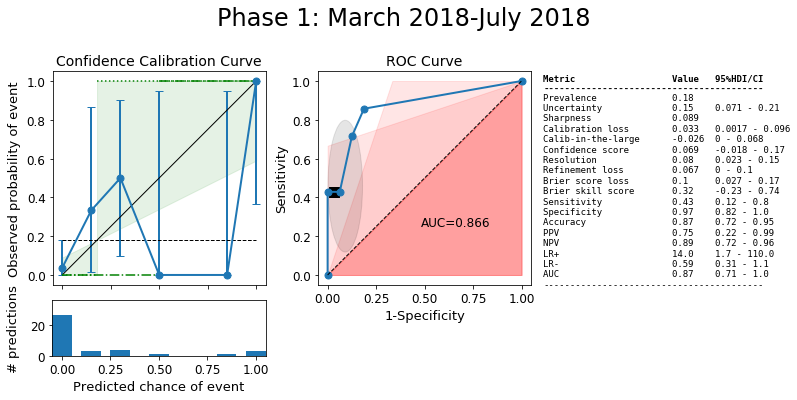

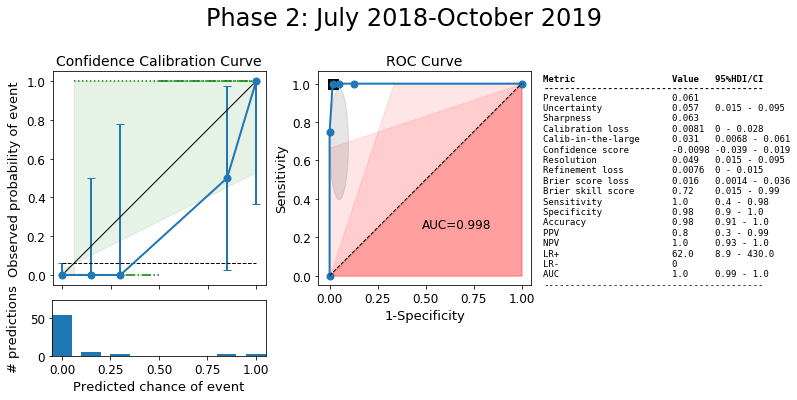

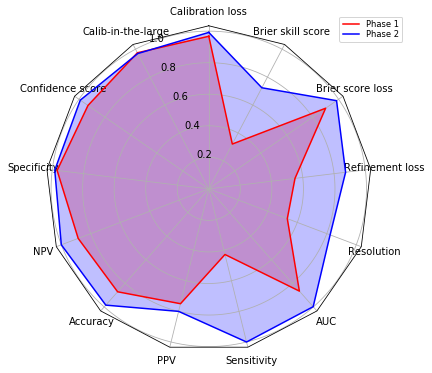

In [18]:
# Performance before and after

d1=np.loadtxt(open("csvs/phase1.csv", "rb"), delimiter=",", skiprows=1)
d2=np.loadtxt(open("csvs/phase2.csv", "rb"), delimiter=",", skiprows=1)

truth1 = d1[:,0]
forecast1 = d1[:,1]

truth2 = d2[:,0]
forecast2 = d2[:,1]

(plt1,metrics1,cm1)=plot_calib_results(truth=truth1,forecast=forecast1,
                                    n_bins=10,
                                    plot_ci=True, 
                                    plot_isoskill=False, 
                                    nplots=3,
                                    fig_title="Phase 1: March 2018-July 2018")
plt1.show()

(plt2,metrics2,cm2)=plot_calib_results(truth=truth2,forecast=forecast2,
                                    n_bins=10,
                                    plot_ci=True, 
                                    plot_isoskill=False, 
                                    nplots=3,
                                    fig_title="Phase 2: July 2018-October 2019")
plt2.show()

array_of_names=['Calibration loss','Calib-in-the-large','Confidence score',
                'Specificity','NPV','Accuracy','PPV','Sensitivity',
                'AUC','Resolution','Refinement loss',
                'Brier score loss', 'Brier skill score']


data_1=create_data_for_radar_plot(metrics1,array_of_names)
data_2=create_data_for_radar_plot(metrics2,array_of_names)
data_radar=data_1
data_radar=[data_1[0],data_1[1],data_2[1]]

p=plot_radar_chart(data=data_radar,forecaster_names=['Phase 1','Phase 2'],plot_file_name='test')
